This notebook produces Annexes figures of the paper ... using the smaller data-files created from the full experiments outputs thanks to the notebook [data_files](data_files.ipynb).

In [2]:
import os
import sys

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import clouddrift as cd
import cmocean.cm as cmo
import IPython
import jax.numpy as jnp
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp
import xarray as xr

from jaxparrow import cyclogeostrophy
from jaxparrow.tools.kinematics import magnitude

In [3]:
# Works in VS-Code only, hard-code it if necessary
nb_dir = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
)
sys.path.append(f"{nb_dir}/src")
sys.path.append(os.path.dirname(nb_dir))

from experiment.preproc import apply_drifter_preproc
from experiment.preproc.drifter import DEFAULT_STEPS

In [4]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

FONT_SIZE = 8

plt.rc("font", size=FONT_SIZE)
plt.rc("axes", titlesize=FONT_SIZE)
plt.rc("axes", labelsize=FONT_SIZE)
plt.rc("xtick", labelsize=FONT_SIZE)
plt.rc("ytick", labelsize=FONT_SIZE)
plt.rc("legend", fontsize=FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_NEUROST_GLOBAL_HW_RATIO = 206 / 496
PLOT_DUACS_GLOBAL_HW_RATIO = 248 / 496
PLOT_GS_HW_RATIO = 213.9 / 496
PLOT_MED_HW_RATIO = (514-293) / (758-645)

# Loading data-files

In [5]:
# CAN / SHOULD BE UPDATED TO REPRODUCE

EXPERIMENTS_PATH = "/mnt/summer/DATA_MEOM/workdir/bertrava/cyclogeostrophy-paper"

DATA_FILES_PATH = f"{nb_dir}/data-files"
FIGURES_PATH = f"{nb_dir}/figures"

# Appendix - drifters

## Drifters - Figure A1

In [5]:
drifter_ds = cd.datasets.gdp6h()
drifter_ds = apply_drifter_preproc(drifter_ds, DEFAULT_STEPS)

In [6]:
neurost_domain = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_snapshot.nc")

In [7]:
drifter_ds = cd.ragged.subset(
    drifter_ds,
    {
        "time": lambda time: (time >= np.datetime64("2010")) & (time <= np.datetime64("2023")),
        "lon": lambda lon: (lon >= neurost_domain.longitude.min().data) & (lon <= neurost_domain.longitude.max().data),
        "lat": lambda lat: (lat >= neurost_domain.latitude.min().data) & (lat <= neurost_domain.latitude.max().data)
    },
    row_dim_name="traj"
)

In [8]:
bin_size = 1
latitude = np.arange(-90, 90, bin_size) + (bin_size / 2)
longitude = np.arange(-180, 180, bin_size) + (bin_size / 2)

binning = pyinterp.Binning2D(pyinterp.Axis(longitude + 180, is_circle=True), pyinterp.Axis(latitude))
binning.push(drifter_ds["lon"] + 180, drifter_ds["lat"], drifter_ds["time"], False)
drifter_counts = binning.variable("count").T

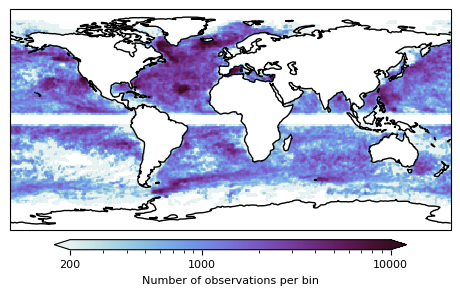

In [9]:
fig_width = MAX_WIDTH
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    longitude, latitude, drifter_counts,
    cmap=cmo.dense, norm=colors.LogNorm(vmin=200, vmax=1e4),
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.66),
    extend="both"
)
clb.set_label(label="Number of observations per bin", size=FONT_SIZE)
tick_labels = [200, 1000, 10000]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fA01.png", dpi=DPI, bbox_inches="tight")

plt.show()

## Error gain / loss - Mean - Figure A2

In [23]:
duacs_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_spatial_binned_errors_ds.nc"
)
neurost_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_spatial_binned_errors_ds.nc"
)

In [24]:
duacs_cg_rmse_gain_loss = (
    duacs_spatial_binned_errors_ds.err_Geostrophy_mean - duacs_spatial_binned_errors_ds.err_Cyclogeostrophy_mean
) / duacs_spatial_binned_errors_ds.err_Geostrophy_mean * 100

neurost_cg_rmse_gain_loss = (
    neurost_spatial_binned_errors_ds.err_Geostrophy_mean - neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_mean
) / neurost_spatial_binned_errors_ds.err_Geostrophy_mean * 100

duacs_neurost_rmse_gain_loss = (
    duacs_spatial_binned_errors_ds.err_Geostrophy_mean - neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_mean
) / duacs_spatial_binned_errors_ds.err_Geostrophy_mean * 100

In [25]:
RMSE_DIFF_REL_MAX = 20


def plot_sd_diff(
    sd_diff: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, sd_diff,
        cmap=cmo.balance_r, vmin=-RMSE_DIFF_REL_MAX, vmax=RMSE_DIFF_REL_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im

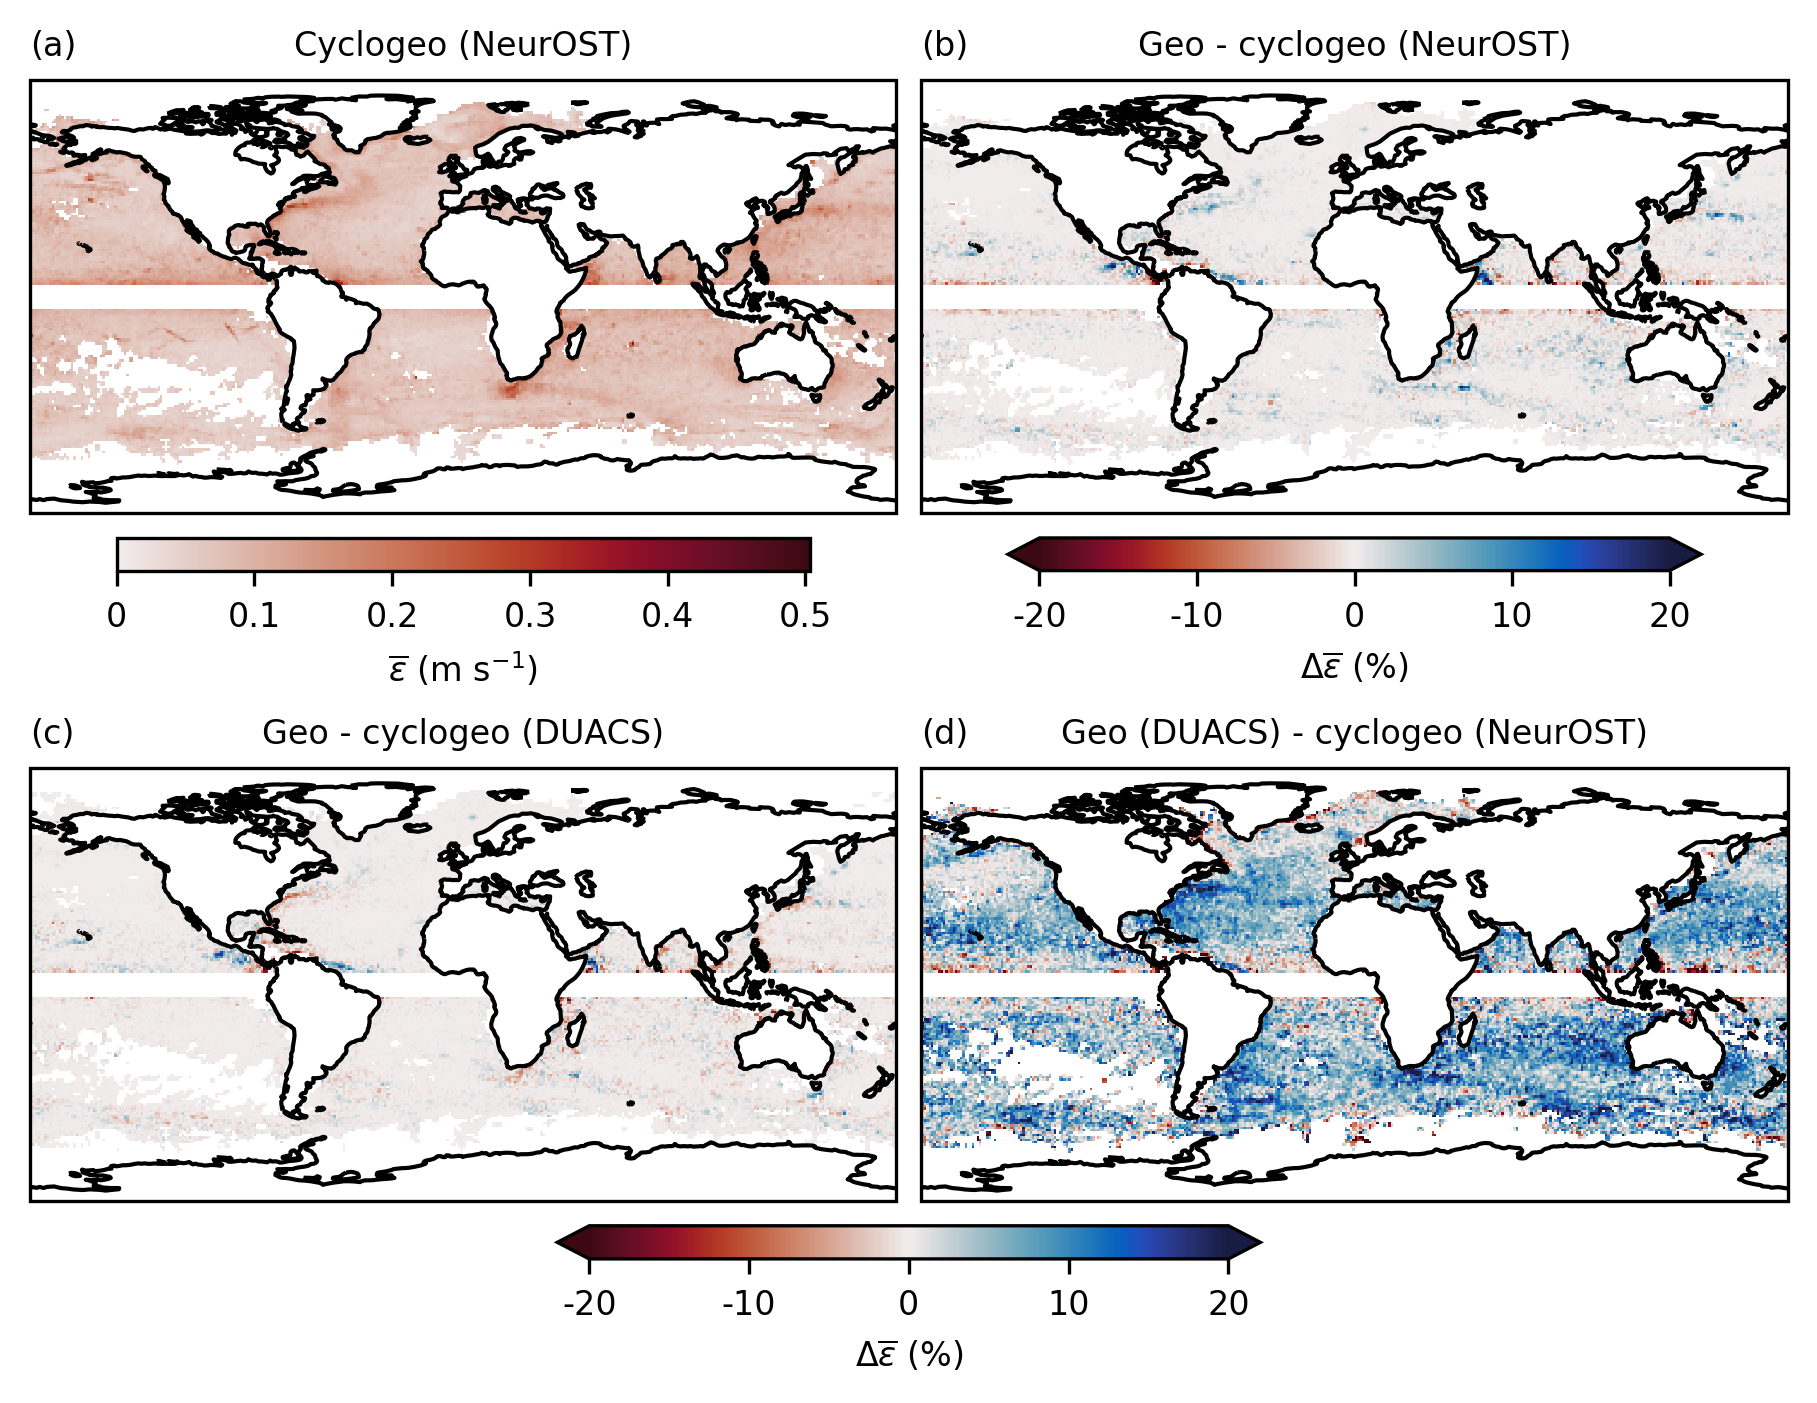

In [26]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im_sd = axd["A"].pcolormesh(
    neurost_spatial_binned_errors_ds.longitude, neurost_spatial_binned_errors_ds.latitude, 
    neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_sd,
    cmap=cmo.amp, vmin=0,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeo (NeurOST)", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

clb_sd = fig.colorbar(
    im_sd, ax=axd["A"], 
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8)
)
clb_sd.set_label(label="$\overline{\\varepsilon}$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0, .1, .2, .3, .4, .5]
clb_sd.set_ticks(tick_labels)
clb_sd.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im_sd_diff = plot_sd_diff(
    neurost_cg_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (NeurOST)",
    "(b)",
    axd["B"]
)

clb_sd_diff1 = fig.colorbar(
    im_sd_diff, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb_sd_diff1.set_label(label="$\Delta\\overline{\\varepsilon}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff1.set_ticks(tick_labels)
clb_sd_diff1.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

_ = plot_sd_diff(
    duacs_cg_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (DUACS)",
    "(c)",
    axd["C"]
)

_ = plot_sd_diff(
    duacs_neurost_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo (DUACS) - cyclogeo (NeurOST)",
    "(d)",
    axd["D"]
)

clb_sd_diff2 = fig.colorbar(
    im_sd_diff, ax=list(axd.values())[2:],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb_sd_diff2.set_label(label="$\Delta\\overline{\\varepsilon}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff2.set_ticks(tick_labels)
clb_sd_diff2.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fA02.png", dpi=DPI, bbox_inches="tight")

plt.show()

## Error / EKE - Mean - Figure A3

In [27]:
neurost_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_eke_binned_errors.nc")
duacs_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_eke_binned_errors.nc")
neurost_it_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_it_eke_binned_errors.nc")
duacs_it_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_it_eke_binned_errors.nc")

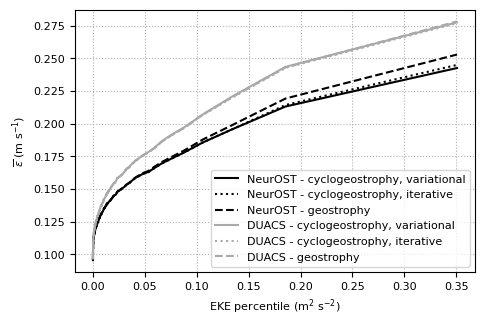

In [28]:
fig, ax = plt.subplots(figsize=(MAX_WIDTH * .75, MAX_WIDTH * .75 * .66))

ax.plot(
    neurost_eke_binned_errors.eke, neurost_eke_binned_errors.err_mean_Cyclogeostrophy, 
    color="k", linestyle="-",
    label="NeurOST - cyclogeostrophy, variational"
)
ax.plot(
    neurost_it_eke_binned_errors.eke, neurost_it_eke_binned_errors.err_mean_Cyclogeostrophy, 
    color="k", linestyle=":",
    label="NeurOST - cyclogeostrophy, iterative"
)
ax.plot(
    neurost_eke_binned_errors.eke, neurost_eke_binned_errors.err_mean_Geostrophy, 
    color="k", linestyle="--",
    label="NeurOST - geostrophy"
)
ax.plot(
    duacs_eke_binned_errors.eke, duacs_eke_binned_errors.err_mean_Cyclogeostrophy, 
    color="darkgrey", linestyle="-",
    label="DUACS - cyclogeostrophy, variational"
)
ax.plot(
    duacs_it_eke_binned_errors.eke, duacs_it_eke_binned_errors.err_mean_Cyclogeostrophy, 
    color="darkgrey", linestyle=":",
    label="DUACS - cyclogeostrophy, iterative"
)
ax.plot(
    duacs_eke_binned_errors.eke, duacs_eke_binned_errors.err_mean_Geostrophy, 
    color="darkgrey", linestyle="--",
    label="DUACS - geostrophy"
)

plt.grid(True, linestyle=':')

ax.legend()

ax.set_xlabel("EKE percentile (m$^2$ s$^{-2}$)", size=FONT_SIZE)
ax.set_ylabel("$\overline{\\varepsilon}$ (m s$^{-1}$)", size=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fA03.png", dpi=DPI, bbox_inches="tight")

plt.show()

## Error / EKE - Distribution - Figure A4

In [10]:
neurost_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_eke_errors.parquet")
duacs_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_eke_errors.parquet")
neurost_it_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_it_eke_errors.parquet")
duacs_it_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_it_eke_errors.parquet")

In [11]:
def get_errors(df, column, x_vals):
    errors = []
    for x_val in x_vals:
        error_values = df[df["eke"] == x_val][column].values
        errors.append(error_values[np.isfinite(error_values)])
    return errors

In [17]:
n_models = 6

x_labels = neurost_eke_errors["eke"].unique()
x_pos = np.arange(x_labels.size)
data = [
    get_errors(neurost_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(neurost_it_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(neurost_eke_errors, "err_Geostrophy", x_labels),
    get_errors(duacs_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(duacs_it_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(duacs_eke_errors, "err_Geostrophy", x_labels)
]
model_labels = [
    "NeurOST - cyclogeostrophy, variational",
    "NeurOST - cyclogeostrophy, iterative",
    "NeurOST - geostrophy",
    "DUACS - cyclogeostrophy, variational",
    "DUACS - cyclogeostrophy, iterative",
    "DUACS - geostrophy"
]
cmap = plt.get_cmap("Set2")
colors = [cmap(i) for i in range(n_models)]
width = .1
offset = np.linspace(-width * n_models / 2, width * n_models / 2, n_models)

In [19]:
data[0][0].size, data[0][1].size, data[0][2].size, data[0][3].size

(96995, 97988, 105849, 78636)

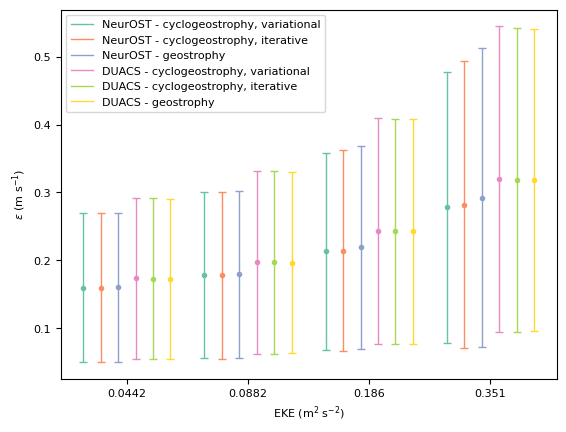

In [44]:
fig, ax = plt.subplots()

for i in range(n_models):
    positions = x_pos + offset[i] * 1.2
    mean = [np.mean(data[i][j]) for j in range(len(data[i]))]
    sd = [np.std(data[i][j]) for j in range(len(data[i]))]
    err_bar = ax.errorbar(
        positions, mean, yerr=sd, fmt="o", color=colors[i],
        label=model_labels[i], capsize=3, elinewidth=1, markersize=3
    )

ax.set_xticks(x_pos)
ax.set_xticklabels([f"{x:.3g}" for x in x_labels], fontsize=FONT_SIZE)
ax.legend([plt.Line2D([0], [0], color=colors[i], lw=1) for i in range(n_models)], model_labels)

ax.set_xlabel("EKE (m$^2$ s$^{-2}$)", size=FONT_SIZE)
ax.set_ylabel("$\\varepsilon$ (m s$^{-1}$)", size=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fA04.png", dpi=DPI, bbox_inches="tight")

plt.show()

# Appendix - SWOT

In [65]:
swot_swath_ds = xr.open_dataset(f"{EXPERIMENTS_PATH}/SWOT_L3_LR_SSH_Expert_546_003_20230608T122942_20230608T132047_v2.0.1.nc")
line_in_med = np.any((swot_swath_ds.latitude >= 36.65) & (swot_swath_ds.latitude <= 43.34), axis=1)
swot_swath_ds = swot_swath_ds.sel(num_lines=line_in_med)  # Mediterranean Sea

In [66]:
ssh_filtered = (swot_swath_ds.mdt + swot_swath_ds.ssha_filtered)

In [67]:
u_cg, v_cg, u_g, v_g, lat_u, lon_u, lat_v, lon_v = cyclogeostrophy(
    jnp.asarray(ssh_filtered),
    jnp.asarray(swot_swath_ds.latitude),
    jnp.asarray(swot_swath_ds.longitude),
    optim_kwargs={"learning_rate": 1e-3},
    return_geos=True
)

u_cg_it, v_cg_it = cyclogeostrophy(
    jnp.asarray(ssh_filtered),
    jnp.asarray(swot_swath_ds.latitude),
    jnp.asarray(swot_swath_ds.longitude),
    method="iterative",
    return_grids=False
)

In [68]:
uv_cg = magnitude(u_cg, v_cg)
uv_cg_it = magnitude(u_cg_it, v_cg_it)
uv_g = magnitude(u_g, v_g)

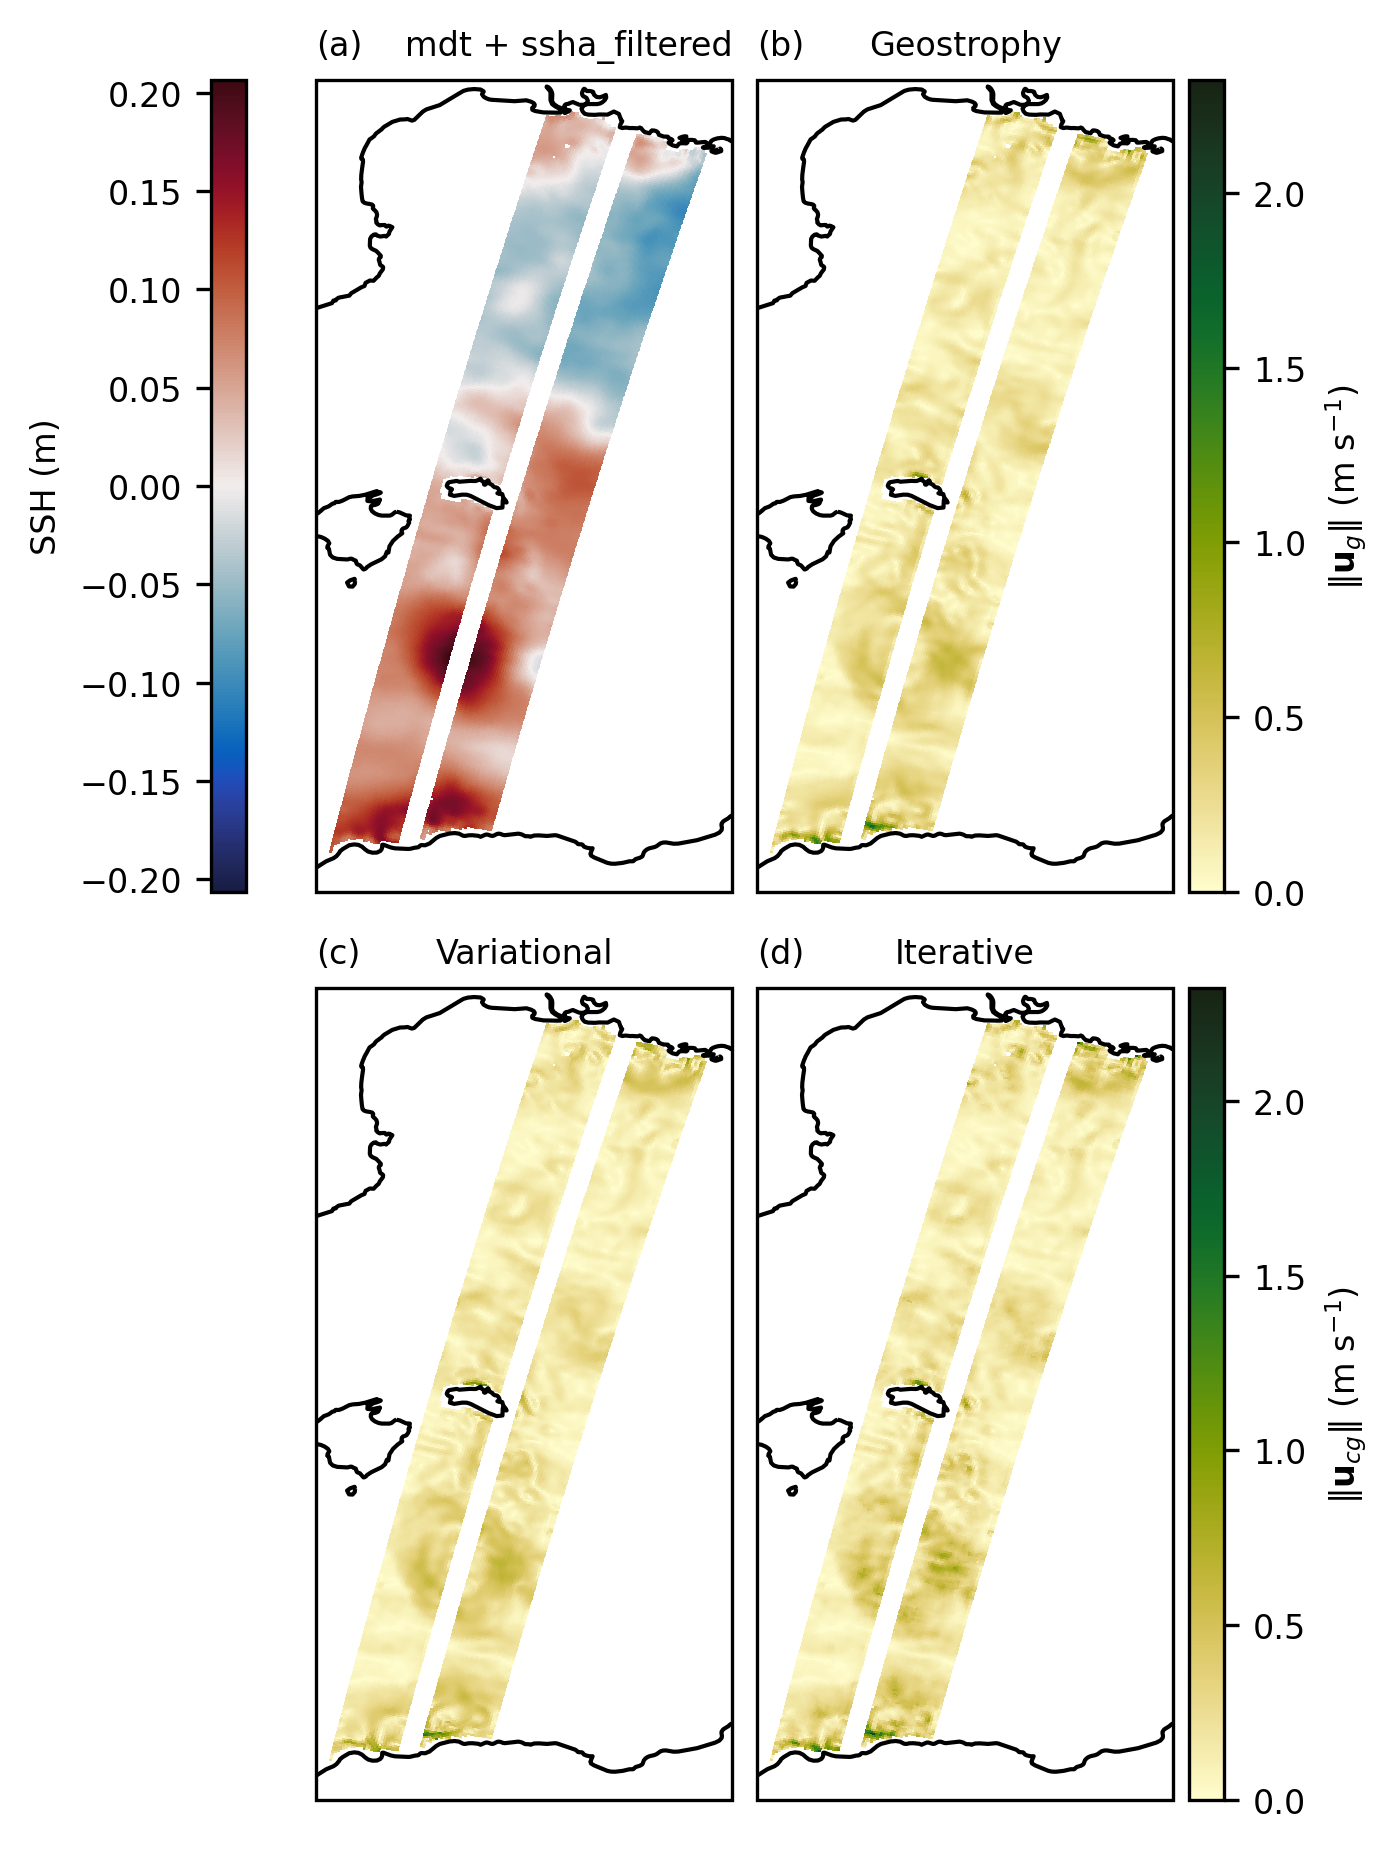

In [69]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        (fig_width - (HW_SPACE) * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE) * n_cols) / n_cols * PLOT_MED_HW_RATIO + 
        (fig_width - (HW_SPACE) * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE) * (n_cols - 1)) / n_cols * PLOT_MED_HW_RATIO + 
        HW_SPACE * (n_rows - 1) + TITLE_H
    ),
    MAX_HEIGHT * .75
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

ssh_max_abs = np.abs(ssh_filtered).max()

im = axd["A"].pcolormesh(
    swot_swath_ds.longitude, swot_swath_ds.latitude, ssh_filtered,
    cmap=cmo.balance, vmin=-ssh_max_abs, vmax=ssh_max_abs,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)
axd["A"].set_title("mdt + ssha_filtered", loc="right", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="left", clb_shrink=1)
)
clb.set_label(label="SSH (m)", size=FONT_SIZE)

uv_max = max(np.nanmax(uv_cg), np.nanmax(uv_cg_it), np.nanmax(uv_g))

im = axd["B"].pcolormesh(
    swot_swath_ds.longitude, swot_swath_ds.latitude, uv_g,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("Geostrophy", fontsize=FONT_SIZE)
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)

im = axd["C"].pcolormesh(
    swot_swath_ds.longitude, swot_swath_ds.latitude, uv_cg,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("Variational", fontsize=FONT_SIZE)
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    swot_swath_ds.longitude, swot_swath_ds.latitude, uv_cg_it,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("Iterative", fontsize=FONT_SIZE)
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fB01.png", dpi=DPI, bbox_inches="tight")

plt.show()

# Appendix - eNATL60

In [72]:
enatl60_coords_ds = xr.open_dataset(f"{EXPERIMENTS_PATH}/eNATL60/alboransea_coordinates.nc")
enatl60_ssh_ds = xr.open_dataset(f"{EXPERIMENTS_PATH}/eNATL60/alboransea_sossheig.nc")    
enatl60_mask_ds = xr.open_dataset(f"{EXPERIMENTS_PATH}/eNATL60/alboransea_mask.nc")

In [ ]:
enatl60_ssh_ds

<xarray.Dataset> Size: 19MB
Dimensions:              (time_counter: 24, y: 146, x: 271, axis_nbounds: 2)
Coordinates:
    nav_lat              (y, x) float32 158kB ...
    nav_lon              (y, x) float32 158kB ...
    time_centered        (time_counter) datetime64[ns] 192B ...
  * time_counter         (time_counter) datetime64[ns] 192B 2009-07-01T00:30:...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    sossheig             (time_counter, y, x) float32 4MB ...
    time_counter_bounds  (time_counter, axis_nbounds, y, x) datetime64[ns] 15MB ...
Attributes: (12/14)
    name:         /scratch/tmp/3735876/eNATL60-BLB002_1h_20090630_20090704_gr...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2018-Dec-30 14:12:09 GMT
    uuid:         929b2b0d-cc1e-447e-beeb-7e9974954873
    ...           ...
    jbegin:       0
    nj:           9
    file_name:    eNATL60-BLB002_1h_20090630_20090704_gridT-2D_20090701-20090...
    TimeStamp:    07/01/2019 17:04:52 +0100
    history:      Mon Dec  7 12:13:42 2020: ncks -O -F -d x,5530,6412 -d y,18...
    NCO:          4.4.6

In [84]:
lat_t = jnp.asarray(enatl60_coords_ds.nav_lat.values)
lon_t = jnp.asarray(enatl60_coords_ds.nav_lon.values)

ssh = jnp.asarray(enatl60_ssh_ds.sossheig[0].values)
mask = 1 - jnp.asarray(enatl60_mask_ds.tmask[0,0].values)

In [74]:
u_cg, v_cg, u_g, v_g, lat_u, lon_u, lat_v, lon_v = cyclogeostrophy(
    ssh,
    lat_t,
    lon_t,
    mask=mask,
    optim_kwargs={"learning_rate": 1e-3},
    return_geos=True
)

u_cg_it, v_cg_it = cyclogeostrophy(
    ssh,
    lat_t,
    lon_t,
    mask=mask,
    method="iterative",
    return_grids=False
)

In [75]:
uv_cg = magnitude(u_cg, v_cg)
uv_cg_it = magnitude(u_cg_it, v_cg_it)
uv_g = magnitude(u_g, v_g)

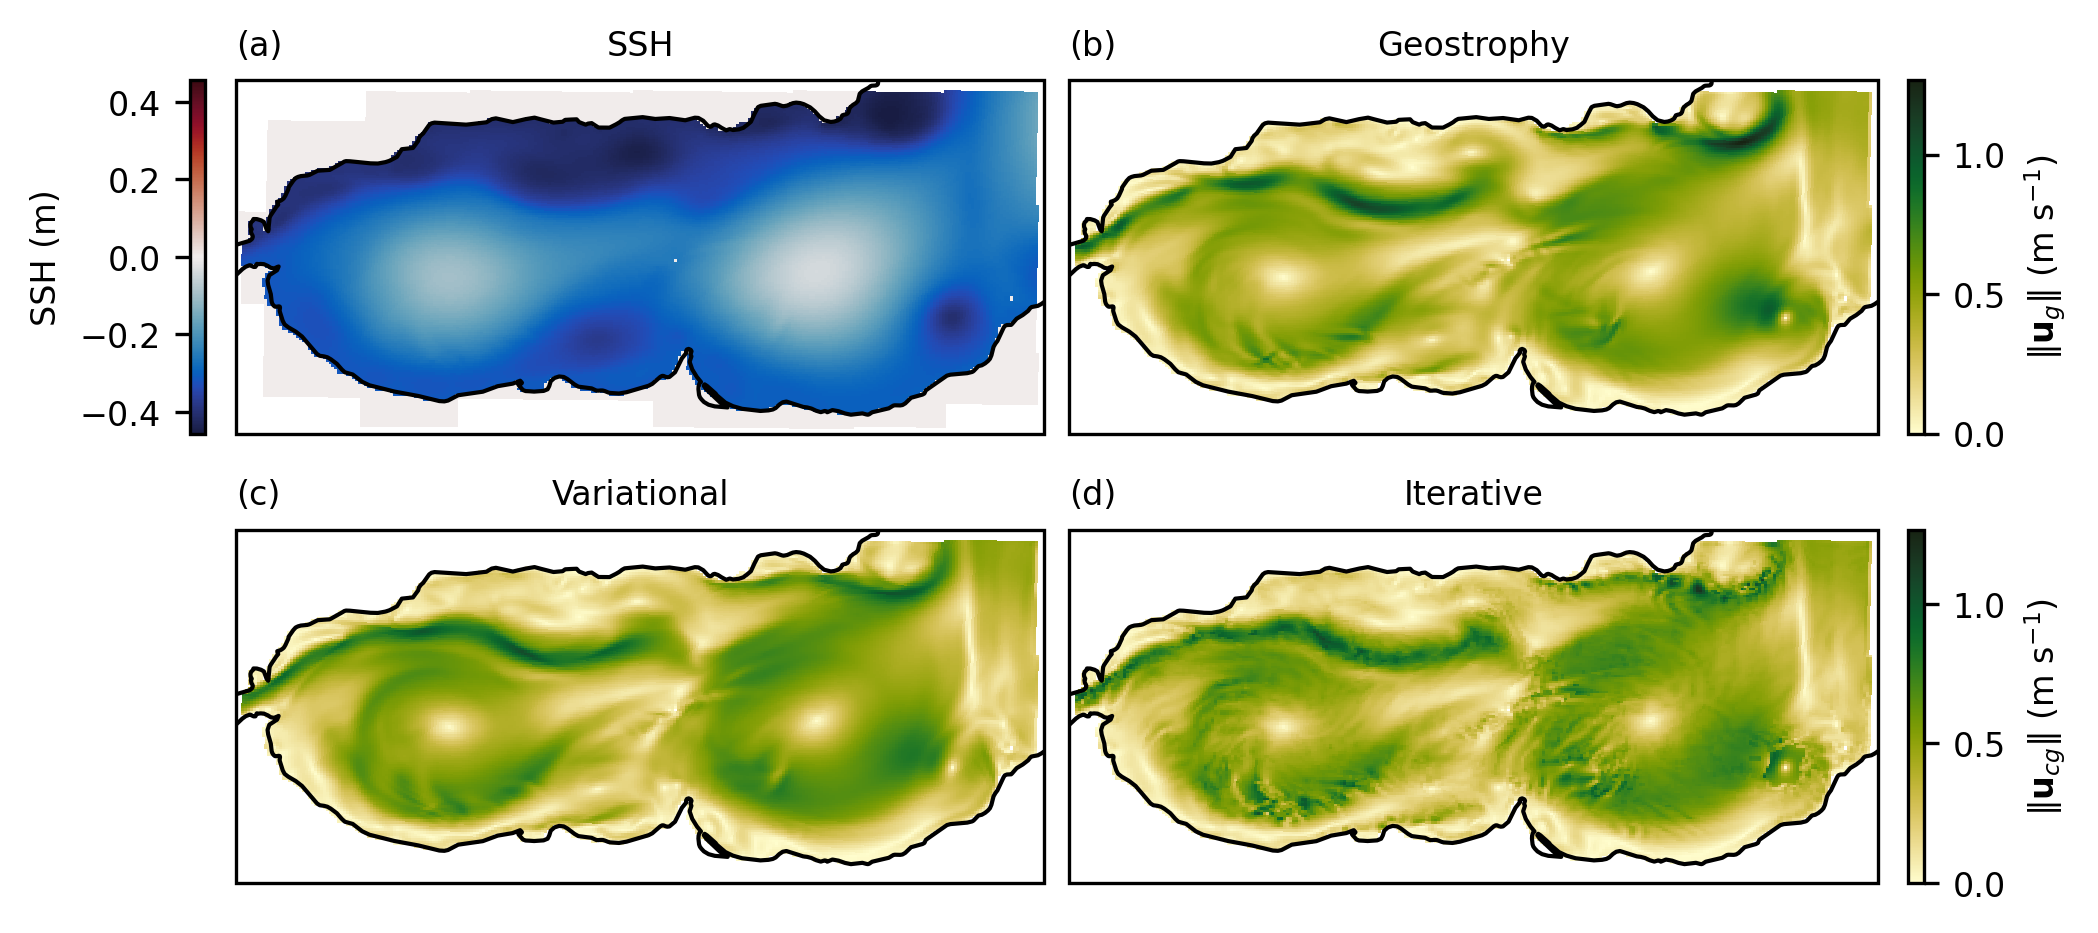

In [89]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        (fig_width - (HW_SPACE) * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE) * n_cols) / n_cols * PLOT_MED_HW_RATIO + 
        (fig_width - (HW_SPACE) * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE) * (n_cols - 1)) / n_cols * PLOT_MED_HW_RATIO + 
        HW_SPACE * (n_rows - 1) + TITLE_H
    ),
    MAX_HEIGHT * .75
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

ssh_max_abs = np.nanmax(np.abs(ssh))

im = axd["A"].pcolormesh(
    lon_t, lat_t, ssh,
    cmap=cmo.balance, vmin=-ssh_max_abs, vmax=ssh_max_abs,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)
axd["A"].set_title("SSH", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="left", clb_shrink=1)
)
clb.set_label(label="SSH (m)", size=FONT_SIZE)

uv_max = max(np.nanmax(uv_cg), np.nanmax(uv_cg_it), np.nanmax(uv_g))

im = axd["B"].pcolormesh(
    lon_t, lat_t, uv_g,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("Geostrophy", fontsize=FONT_SIZE)
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)

im = axd["C"].pcolormesh(
    lon_t, lat_t, uv_cg,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("Variational", fontsize=FONT_SIZE)
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    lon_t, lat_t, uv_cg_it,
    cmap=cmo.speed, vmin=0, vmax=uv_max,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("Iterative", fontsize=FONT_SIZE)
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/fC01.png", dpi=DPI, bbox_inches="tight")

plt.show()